## Glucose: Transfer Component Analysis (TCA)

In [101]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression as PLSR
from traintest import *
import itertools
from visualization import *
from dataloader import DataLoad
from tca import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Loading Data

In [102]:
glucose = True
D = DataLoad(glucose=glucose)
D.load_data()
Xs, ys, Xt, yt, wl = D.X_source, D.y_source, D.X_target, D.y_target, D.wl

### 2. Training Model on Source Data and Test on Target Data (Baseline Model, No Domain Adaptation)

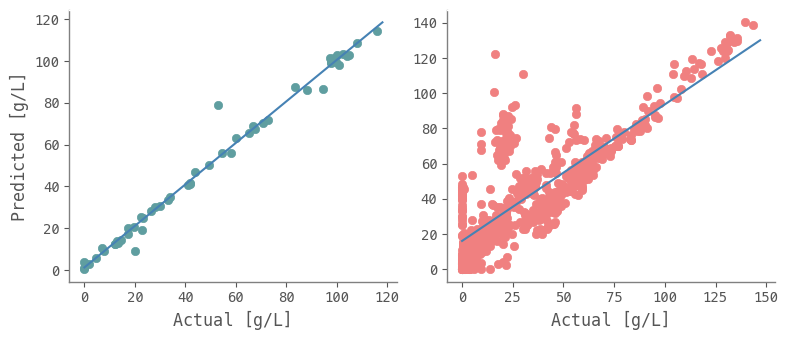

  Test on Model  R-sq      RMSE RMSEP [%]  RPD
0  Source  PLSR  0.99   4.41191   3.81361  8.3
1  Target  PLSR  0.57  20.42566  14.21251  1.5


In [103]:
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, test_size=0.2, random_state=42)
models = train(Xs_train, ys_train, plsr_comp=12)
print(test(models, Xs_test, ys_test, Xt, yt))

### 3. Hyper Parameter Tuning for Transfer Component Analysis

In [106]:


# Grid search for TCA and PLSR components
best_score = float('inf')
best_params = {}
tca_kernel = ['linear', 'rbf']
tca_dims = [10, 20]
tca_lambdas = [0.001, 0.01, 0.1]
tca_gammas = [0.001, 0.01, 0.1]
plsr_components = [10, 12, 15]

for kern, dim, lamb, gamma, n_comp in itertools.product(tca_kernel, tca_dims, tca_lambdas, tca_gammas, plsr_components):
    tca = TCA(kernel_type=kern, dim=dim, lamb=lamb, gamma=gamma)
    Xs_train_tca, Xt_tca = tca.fit_transform(Xs_train, Xt)

    Xs_train_split, Xs_val, ys_train_split, ys_val = train_test_split(Xs_train_tca, ys_train, test_size=0.2, random_state=42)   
    
    n_comp_ = min(n_comp, dim)
    pls = PLSR(n_components=n_comp_)
    
    
    pls.fit(Xs_train_split, ys_train_split)

    y_pred = pls.predict(Xs_val)

    rmse = MSE(ys_val, y_pred, squared=False)

    if rmse < best_score:
        best_score = rmse
        best_params = {
            'tca_kernel': kern,
            'tca_dim': dim,
            'tca_lambda': lamb,
            'tca_gamma': gamma,
            'plsr_components': n_comp_,
            'val_rmse': rmse
        }

best_params

{'tca_kernel': 'rbf',
 'tca_dim': 20,
 'tca_lambda': 0.001,
 'tca_gamma': 0.01,
 'plsr_components': 12,
 'val_rmse': 3.8877392325554823}

### 4. Evaluate Domain Adaptation Performance of TCA

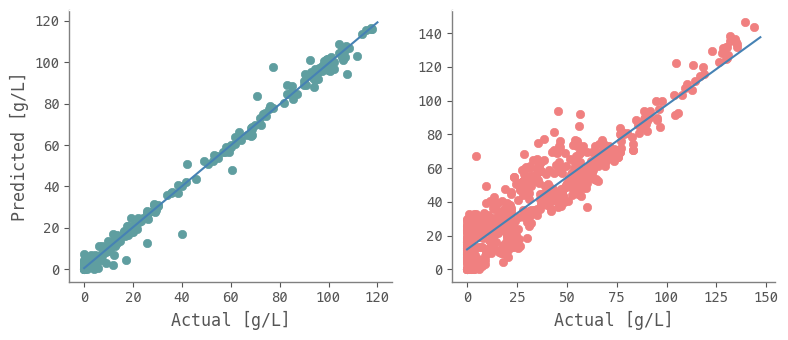

  Test on Model  R-sq      RMSE RMSEP [%]   RPD
0  Source  PLSR  0.99   3.84533   3.25995  10.3
1  Target  PLSR  0.81  13.59017   9.45627   2.3


In [107]:
# TCA transform
tca = TCA(kernel_type=best_params['tca_kernel'], dim=best_params['tca_dim'], lamb=best_params['tca_lambda'], gamma=best_params['tca_gamma'])
Xs_new, Xt_new = tca.fit_transform(Xs_train, Xt)


models = train(Xs_new, ys_train, plsr_comp=best_params['plsr_components'])
print(test(models, Xs_new, ys_train, Xt_new, yt))